# Minilab 2

<b>Class:</b> MSDS 7331 Data Mining
<br> <b>Dataset:</b> Belk Endowment Educational Attainment Data 

<h1 style="font-size:150%;"> Teammates </h1>
Maryam Shahini
<br> Murtada Shubbar
<br> Michael Toolin
<br> Steven Millett

In [2]:
#Set global variables
#Number of features we will be selecting for feature selection

N_FEATURES_OPTIONS = [25 , 50, 100, 200, 300]


#Alpha and C we will be using for our classifiers

C_OPTIONS = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]


#Import data all necessary libraries we will be using in our estimation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from pandas.plotting import scatter_matrix
import seaborn as sns
import math
import re
import sklearn
import statistics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold

from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile

from sklearn.feature_selection import RFE

from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from IPython.display import display, HTML

from sklearn.pipeline import Pipeline

from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Binarizer

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
# The 2017 Public Schools Machine Learning 
# Date Set is being used throughout this 
# analysis.  The _ML suffix is removed to less 
# name space size
# Load Full Public School Data Frames for each year

school_data = pd.read_csv('../Data/2017/Machine Learning Datasets/PublicSchools2017_ML.csv', low_memory=False)

print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.19.1.


# Create Models
Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 

In [4]:
#split data into X and y dataframes

SPG_Grade_col = school_data.filter(regex=('^SPG\WGrade')).columns
y = school_data[SPG_Grade_col].apply(lambda row:'A' if row.any()!=1 else 
                                 row[0]*'A+NG'+row[1]*'B'+row[2]*'C'+row[3]*'D'+row[4]*'F'+row[5]*'I',axis=1)

#Removed SPG Grade and unit code(which is primary key for school data table)
 
X = school_data[school_data.columns.drop(list(school_data.filter(regex='^SPG\WGrade|^SPG\WScore|unit_code')))]

In [5]:
# split X and y into test and train sets. We still want
# to do this for external Cross Validation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

# Training of the model

Here we are training the logistic regression, SVM, and SGDClassifier models. We are using 10 k-fold internal cross validation to train and test our model. A simple pipeline was created which and then grid search was used for parameter selection. The pipeline has 3 main steps:
1. dimension reduction
2. sample scaling
3. classification

The grid search will try the following parameters for each of the 3 steps:
1. dimension reduction - None, NMF, PCA
1. a. Number of obersations - 25 , 50, 100, 200, 300
2. sample scaling - None, Standard Scaler
3. model classification - Logistic Regression, SVM, SGDClassifier
3. a. Number of options used for classifiers - 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4

In [6]:
# Here we establish a basic 10 k-fold internal
# Cross Validation seperation that will be used
# for training our model.

k_fold = KFold(n_splits=10,shuffle=True)

#This creates the template for the pipeline
# This creates a basic pipeline where we will 
# test for dementionality reduction, scaling,
# and classification.

pipe = Pipeline([('reduce_dim', NMF()),
                  ('scale', StandardScaler()), 
                  ('clf', LogisticRegression())])

In [7]:
# #Don't run this unless you want to retrain the data.

# Here we are establishing the basic testing criteria
# for our pipeline. This will run through a number of
# parameters for our pipeline, including type of dimensionality
# reduction, number of features to reduce, scaling (yes/no), 
# classification models, and parameters of the classification model.

param_grid = [
    {
        'reduce_dim': [None],
        'scale':[None,StandardScaler()],
        'clf':[SVC(),LogisticRegression()],
        'clf__C': C_OPTIONS
    },
    {
        'reduce_dim': [None],
        'scale':[None,StandardScaler()],
        'clf':[SGDClassifier(tol=1e-3,max_iter=1000)],
        'clf__alpha': C_OPTIONS
    },
    {
        'reduce_dim': [NMF(), PCA()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'scale':[None,StandardScaler()],
        'clf':[SVC(),LogisticRegression()],
        'clf__C': C_OPTIONS
    },
    {
        'reduce_dim': [NMF(), PCA()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'scale':[None,StandardScaler()],
        'clf':[SGDClassifier(tol=1e-3,max_iter=1000)],
        'clf__alpha': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'scale':[None,StandardScaler()],
        'clf':[SVC(),LogisticRegression()],
        'clf__C': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'scale':[None,StandardScaler()],
        'clf':[SGDClassifier(tol=1e-3,max_iter=1000)],
        'clf__alpha': C_OPTIONS
    },   
]


# This will test the parameter dict against our 
# pipeline

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=k_fold,n_jobs=-1, verbose=1 )


# Here we are training the model, this is 
# what takes the most amount of time to run
grid_search.fit(X_train, y_train)


#This saves the grid_search variable
# to an external file so we don't have to 
# keep running the gridsearch

from sklearn.externals import joblib
joblib.dump(grid_search, 'savedBestModel.pkl')

Fitting 10 folds for each of 864 candidates, totalling 8640 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 1138 tasks      | elapsed: 42.5min
[Parallel(n_jobs=-1)]: Done 1688 tasks      | elapsed: 85.6min
[Parallel(n_jobs=-1)]: Done 2338 tasks      | elapsed: 131.4min
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed: 189.0min
[Parallel(n_jobs=-1)]: Done 3938 tasks      | elapsed: 254.6min
[Parallel(n_jobs=-1)]: Done 4888 tasks      | elapsed: 326.6min
[Parallel(n_jobs=-1)]: Done 5938 tasks      | elapsed: 399.0min
[Parallel(n_jobs=-1)]: Done 7088 tasks      | elapsed: 404.3min
[Parallel(n_jobs=-1)]: Done 8338 tasks      | elapsed: 408.1min
[Parallel(n_jobs=-1)]: Done 8640 out of 8640 | elapsed: 408.9min finished


['savedBestModel.pkl']

In [8]:
#Run this to load the model from the save file

from sklearn.externals import joblib
grid_search = joblib.load('savedBestModel.pkl')


# Loads all parameters run into a dict 

params = np.array(grid_search.cv_results_['params'])


# Loads all mean test scores into an array

mean_scores = np.array(grid_search.cv_results_['mean_test_score'])

,0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0
SVC,0.400205,0.400205,0.400205,0.719550,0.860798,0.866940,0.865916,0.865916,0.865916
LogisticRegression,0.812692,0.812692,0.833675,0.836233,0.825998,0.816786,0.804504,0.798874,0.797851
SGDClassifier,0.822927,0.823439,0.822927,0.826510,0.804504,0.567554,0.469806,0.460594,0.465200


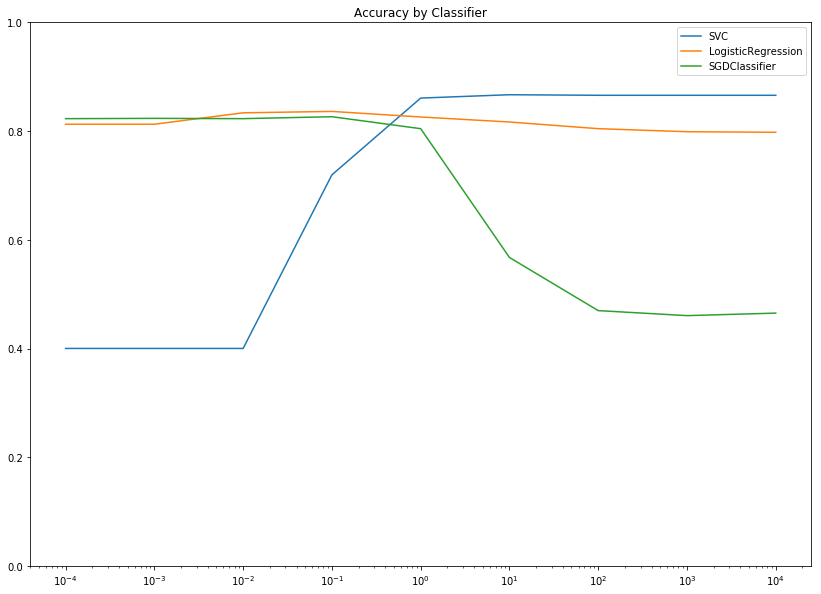

In [9]:
# Assigns all models to an array

classifier_labels=['SVC','LogisticRegression','SGDClassifier']


# Creates an empty dataframe that is to be
# filled with the mean test accuracy by C global
# variable and the different classifiers

classifier_temp = pd.DataFrame(columns=classifier_labels,index=C_OPTIONS,
                               data=np.linspace(.1,.25,num=len(C_OPTIONS)*len(classifier_labels)).reshape(len(C_OPTIONS),len(classifier_labels)))
classifier_temp.fillna(0,inplace=True)

for i, (param, score) in enumerate(zip(params, mean_scores)):
    C = param['clf__C'] if 'clf__C' in param else param['clf__alpha']
    class_state = str(param['clf']).split('(')[0]
    if classifier_temp.at[C,class_state] < score:
        classifier_temp.at[C,class_state] = score


# Printing a grid of the best accuracies
        
display(classifier_temp.transpose())   


# Print a line plot which shows the best 
# accuracies
 
classifier_temp.plot(logx=True,ylim=(0,1),figsize=(14,10),title='Accuracy by Classifier'); 

,25,50,100,200,300,None
NMF,0.686285,0.712897,0.769703,0.759468,0.751791,0.863869
PCA,0.758956,0.757421,0.752815,0.761515,0.813204,0.241176
SelectKBest,0.767144,0.828045,0.838280,0.864381,0.866940,0.863869


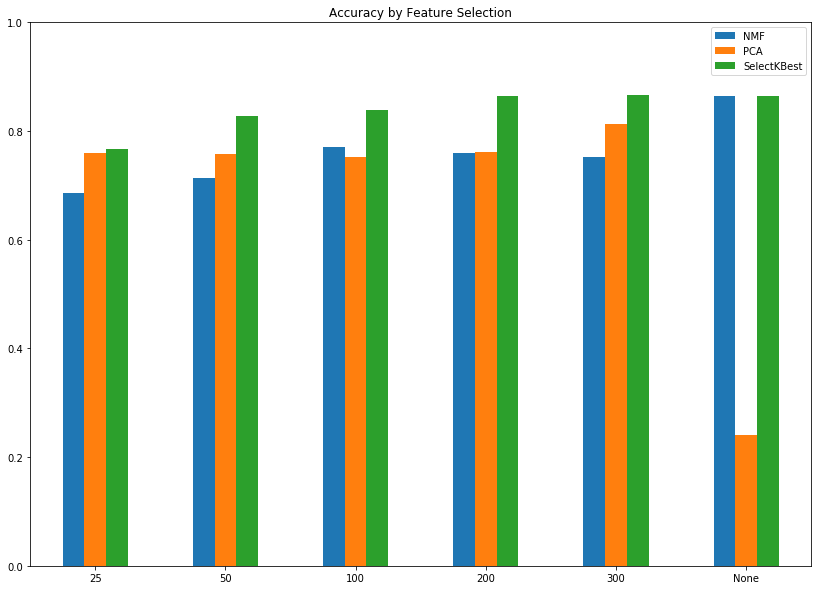

In [10]:
# Assigns all reduction models to an array

reduce_labels=['NMF','PCA','SelectKBest']


# Translates the N Features array
# to an array full of string

temp_N_FEATURES_OPTIONS = [str(r) for r in N_FEATURES_OPTIONS]
temp_N_FEATURES_OPTIONS=temp_N_FEATURES_OPTIONS+['None']


# Creates an empty dataframe that is to be
# filled with the mean test accuracy by N Features
# variable and the different feature reduction models

reduce_temp = pd.DataFrame(columns=reduce_labels,index=temp_N_FEATURES_OPTIONS,
                               data=np.linspace(.1,.25,num=len(temp_N_FEATURES_OPTIONS)*len(reduce_labels)).reshape(+len(temp_N_FEATURES_OPTIONS),len(reduce_labels)))


for i, (param, score) in enumerate(zip(params, mean_scores)):
    trigger=0
    reduce_state = str(param['reduce_dim']).split('(')[0]
    if 'reduce_dim__k' in param:
        N_FEAT = str(param['reduce_dim__k'])
        trigger=1
    elif 'reduce_dim__n_components' in param:
        N_FEAT = str(param['reduce_dim__n_components'])
        trigger=1
    else:
        if reduce_temp.at['None','NMF'] < score:
            reduce_temp.at['None','NMF'] = score
            reduce_temp.at['None','SelectKBest'] = score
    if trigger == 1:
        if reduce_temp.at[N_FEAT,reduce_state] < score:
            reduce_temp.at[N_FEAT,reduce_state] = score

            
# Printing a grid of the best accuracies

display(reduce_temp.transpose())


# Print a bar plot which shows the best 
# accuracies

reduce_temp.plot(kind='bar',ylim=(0,1),figsize=(14,10),title='Accuracy by Feature Selection',rot=0);           

In [11]:
print('The Index of the best model is',grid_search.best_index_)
print('The parameters of the best model is')
display(grid_search.best_params_)
print('The accuracy of the best model is',round(grid_search.best_score_*100,4))

The Index of the best model is 653
The parameters of the best model is


{'clf': SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
 'clf__C': 10.0,
 'reduce_dim': SelectKBest(k=300, score_func=<function chi2 at 0x7f04a68ee268>),
 'reduce_dim__k': 300,
 'scale': StandardScaler(copy=True, with_mean=True, with_std=True)}

The accuracy of the best model is 86.694


# Model Advantages
Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

Looking at the accuracy of the two models there are a couple of obvious observations.

1. SVM is negatively to non-standardized observations.
2. Logistic Regression ...

# Interpret Feature Importance
Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?


In [12]:
best_score=0
ind = 0


# Figure out the index of the best 
# model based on LogisticRegression

for index, (param, score) in enumerate(zip(params, mean_scores)):
    # Uses split to get the first part of the 
    # clf dict, which is the classifier used
    class_state = str(param['clf']).split('(')[0]
    if class_state == 'LogisticRegression' and score>best_score:
        best_score=score
        ind=index

# Sets parameters to the best found with
# the index

pipe.set_params(**grid_search.cv_results_['params'][ind])
pipe.fit(X_train,y_train)

#Gets the predicted coefficients for the pipeline

coef = pipe.steps[2][1].coef_

#Creates a boolean mask based on the Kbest selection
mask = pipe.steps[0][1].get_support()
new_features= []

#Creates a list of names from the columns of the original dataset
feature_names = list(X.columns.values)

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

#Creates a new dataframe with the coefficients and the 
predicted_data = pd.DataFrame(coef, columns=new_features)

# Predicts the prediction of the y test
y_pred = pipe.predict(X_test)

# Assigns the accuracy of the external cross validation 
accuracy = accuracy_score(y_test,y_pred)


print('The accuracy of the best Logistic Regression is',round(accuracy*100,4))
        
#Add the square of every column together to get the most influential predictors
sum1 = predicted_data.apply(lambda row: (row**2).sum(),axis=0)
#sum2 = predicted_data.apply(lambda row: abs(row).sum(),axis=0)

print("The top 10 features that influence SPG Grade are the following")

display(sum1.sort_values(ascending=False)[0:200])

The accuracy of the best Logistic Regression is 83.4356
The top 10 features that influence SPG Grade are the following


State Gap Compared_Y                                      3.227053
Reading SPG Grade_C                                       2.266282
Math SPG Grade_C                                          1.970883
Reading SPG Grade_B                                       1.349541
Math SPG Grade_B                                          1.319443
EVAAS Growth Status_NotMet                                1.283206
Reading SPG Grade_D                                       0.997239
EOG/EOCSubjects_CACR_All                                  0.927198
Math SPG Grade_D                                          0.903086
EVAAS Growth Score                                        0.822498
Math SPG Grade_F                                          0.556266
Reading SPG Grade_F                                       0.455630
EOG/EOCSubjects_CACR_EDS                                  0.446138
school_type_txt_Regular School                            0.432964
short_susp_per_c_num                                      0.39

# Interpret Support Vectors
Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.

In [13]:
#This will search for the best logistic regression model from the previously run grid search

best_score=0
ind = 0


# Figure out the index of the best 
# model based on SVM

for index, (param, score) in enumerate(zip(params, mean_scores)):
    # Uses split to get the first part of the 
    # clf dict, which is the classifier used
    class_state = str(param['clf']).split('(')[0]
    if class_state == 'SVC' and score>best_score:
        best_score=score
        ind=index

# Sets parameters to the best found with
# the index

pipe.set_params(**grid_search.cv_results_['params'][ind])
pipe.fit(X_train,y_train)


# Predicts the prediction of the y test

y_pred = pipe.predict(X_test)

# Assigns the accuracy of the external cross validation 

accuracy = accuracy_score(y_test,y_pred)


print('The accuracy of the best SVM is',round(accuracy*100,4))
        

The accuracy of the best SVM is 85.6851
